# Data science challenge

We are given the following dataset:

In [1]:
import pandas
df = pandas.read_csv("aft100k.csv")
print(df.head(10))

   creative_id user_operating_system       user_device  \
0       113521               Android             Phone   
1       115340               Windows  PersonalComputer   
2       113582               Android             Phone   
3        97385               Windows  PersonalComputer   
4       114821               Windows  PersonalComputer   
5       113065               Android            Tablet   
6       111414                   iOS             Phone   
7       111414                   iOS             Phone   
8       112705               Windows  PersonalComputer   
9       113176                 macOS  PersonalComputer   

   average_seconds_played      cost  revenue  
0                     NaN  0.010128      0.0  
1                0.000000  0.005937      0.0  
2                7.142857  0.004398      0.0  
3                     NaN  0.006157      0.0  
4                     NaN  0.001994      0.0  
5                     NaN  0.003781      0.0  
6               17.000000  0.002

- creative_id: A unique identifier of the video that has been displayed to the user
- user_operating_system: The user Operating System (OS)
- user_device: The user device type
- average_seconds_played: The average number of seconds the user usually watches our videos (only if we already know the user, based on the user history)
- cost: The cost we had to pay to display the video
- revenue: The revenue generated by this video when it has been watched


## Preliminary questions

####  1) The margin being defined as (revenue - cost) / revenue, what is our global margin based on this log?

In [2]:
print("Are there null revenues? {}".format(df["revenue"].isnull().values.any()))
print("Are there null costs? {}".format(df["cost"].isnull().values.any()))

Are there null revenues? False
Are there null costs? False


In [3]:
revs = df["revenue"].sum()
costs = df["cost"].sum()
margin = (revs-costs)/revs
print("Global margin is {0:.4f}, or {1:.2f}%".format(margin, margin*100))

Global margin is 0.2719, or 27.19%


#### 2) Can you think of other interesting metrics to optimize

Metrics to optimize:

1) Profits - No explanation needed.

2) Profits per device - We want to make sure all devices are profitable.

3) Profits per OS - We want to make sure all OSs are profitable.

4) Profits per video - We want to make sure all ads are profitable.

I would also like to understand why sometimes it takes more seconds than others to get the money - some of them don't make us any money in 30 seconds, some of them do in 10 seconds. I guess it is very possible that we are losing money in some type of ads. Maybe we should only display them in certain platforms where people is willing to spend more time watching ads - and this is a metric we could get from our csv, the number of seconds per device.

Moreover, it may be important for our clients two traditional metrics that don't appear in the csv: Click-through rate (CTR) and Conversion rate.



#### 3) What are the most profitable Operating Systems?

In [4]:
df_agg = df[['user_operating_system','cost', 'revenue']].groupby(
    ['user_operating_system']).sum()
series_profits = df_agg["revenue"]-df_agg["cost"]
print("Most profitable OSs:")
display(series_profits.sort_values(ascending=False))

Most profitable OSs:


user_operating_system
iOS              115.521775
Windows           65.873808
Android           27.279364
OS X               1.707775
Chrome OS          0.428130
Linux              0.372922
macOS              0.248021
Fire OS            0.142575
unknown            0.093995
BlackBerry OS      0.077391
BSD                0.040430
RIM OS            -0.005229
dtype: float64

The only real profitability comes from iOS, Windows and Android - anything else is barely profitable.

## Machine learning questions

#### How would you use this historical data to predict the event 'we benefit from a revenue' (i.e. revenue > 0) in a dataset where the revenue is not known yet?

#### Compute the prediction accuracy of a well chosen algorithm and comment the results. Do not hesitate to describe your methodology.

The problem at hand is a problem of supervised learning, in particular, it is a regression problem. We need to build a regressor from our dataset, using:

- Five features: *creative_id, user_operating_system, user_device, average_seconds_played, cost*. 
- A label: *revenues*.
- A regression algorithm: We have a dataset with 100 000 examples - that is pretty good to use some of the more complex algorithms like SVMs with kernels, or ensemble learning (random forests, adaboost). Neural networks could also be considered but, considering the scope of this work, it would take too long to train and optimize.


In order to validate our results, we will divide the dataset in 2, training set (80%) and test set (20%). Cross validation with several bags would be a better technique, but it would take longer.

Before doing this, and just in case our data has some hidden time sequentiality, let's shuffle the data.

In [5]:
from sklearn.utils import shuffle

df = shuffle(df)

df_train = df[:len(df)*4//5]
df_test = df[len(df)*4//5:]

##### Feature Generation

Feature generation is one of the most important processes in data science. A good result is accomplished thanks to domain expertise, proper data visualization, and trial and error - but this are in general too time consuming for the scope of the project.

Some interesting features we could investigate are:

1) Interactions: Interaction between the videos (creative_id) and the user device, or with the video and the operating system.

2) Binning: Create bins in case there is some skewness in a variable - for example, in our case, most of the distribution is close to the min.

##### Data cleaning:

The first problem we face is that the features user_device and average_seconds_played are not present in some examples of the data set - or, in pandas' jargon, they are NaNs.

In [6]:
feature_cols = ['creative_id', 'user_operating_system', 'user_device', 
                'average_seconds_played', 'cost']
label_col = ['revenue']

X_train = df_train.loc[:, feature_cols]
y_train = df_train[label_col]

print(X_train.isnull().sum())
print(y_train.isnull().sum())

creative_id                   0
user_operating_system         0
user_device                   6
average_seconds_played    49427
cost                          0
dtype: int64
revenue    0
dtype: int64


In the case of *user_device*, it is not a big problem (only 8 labels out of 100 000, we can discard 8 without any second thoughts). Also substituting the NaNs for the average or something similar is tricky since this is a categorical feature (i.e., a string) - we could use the most frequent value but, again, there is no need. 


In [7]:
y_train = y_train[-X_train["user_device"].isnull()]
X_train = X_train[-X_train["user_device"].isnull()]

In the case of *average_seconds_played*, the problem is different: more than half of the data does not contain a value for the feature. However in this case, this is a numerical feature which gives us two options:

1) Removal: We would end up with around 40% of the dataset. The impact of this could be huge, but at least we are not "tampering" the data.

2) Substituting the data with its average, mode or median. This looks more promising, and it will be our default approach.

It could be interesting to compare the performances of both options, but for the scope of this work lets limit ourselves to the second option.

In [8]:
import numpy as np
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train["average_seconds_played"] = imp.fit_transform(X_train[["average_seconds_played"]])

##### Data visualization

Here is some very basic information from the dataset.

In [9]:
X_train.describe()

creative_id  average_seconds_played          cost
count   79994.000000            79994.000000  79994.000000
mean   112158.229767               10.584672      0.005678
std      5245.984360                6.041412      0.003508
min     50634.000000                0.000000      0.000473
25%    112167.000000               10.584672      0.003308
50%    113521.000000               10.584672      0.005229
75%    114948.000000               10.584672      0.006616
max    115465.000000              175.000000      0.052878

Let's use some bar plots for the categorical features:

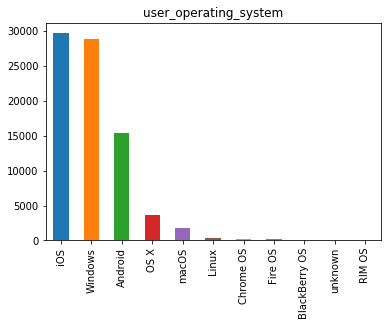

In [10]:
%matplotlib inline

X_train["user_operating_system"].value_counts().plot(kind='bar', title='user_operating_system')

We can see that our sample is mostly with iOS and Windows, and also some Android.

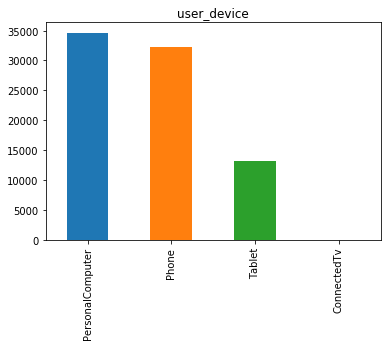

In [11]:
%matplotlib inline

X_train["user_device"].value_counts().plot(kind='bar', title='user_device')


We can appreciate that connected TVs are almost non existent.

For the numerical features, we have the following:

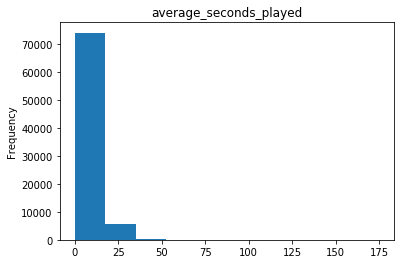

In [12]:
%matplotlib inline

X_train["average_seconds_played"].plot(kind='hist', title='average_seconds_played')

This calls for transformations. Let's try with a log transformation instead, with a logarithmic y-axis for better visualization. 

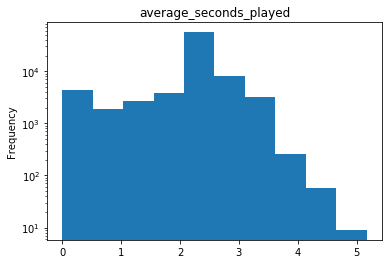

In [13]:
%matplotlib inline

X_train["average_seconds_played"] = pandas.Series(np.log1p(X_train["average_seconds_played"]))
X_train["average_seconds_played"].plot(kind='hist', logy=True, title='average_seconds_played')

This looks more like a normal distribution (actually, like a Laplace distribution due to its high kurtosis).

For the cost, this is what the histogram looks like:

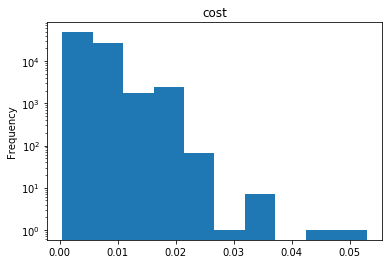

In [14]:
%matplotlib inline

X_train["cost"].plot(kind='hist', logy=True, title='cost')

Again, this calls for transformations. The log transformation does not work well, but the boxcox does.

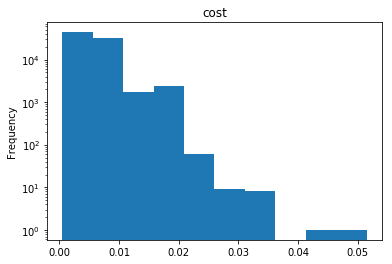

In [15]:
%matplotlib inline

pandas.Series(np.log1p(X_train["cost"])).plot(kind='hist', logy=True, title='cost')

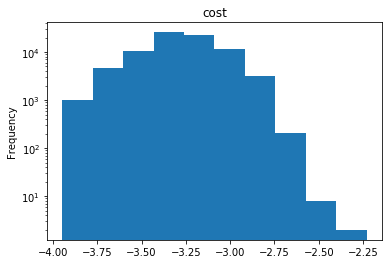

In [16]:
%matplotlib inline

from scipy.stats import boxcox
boxcox, _ = boxcox(X_train["cost"])
boxcox = pandas.Series(boxcox)

boxcox.plot(kind='hist', logy=True, title='cost')

In [17]:
X_train["cost"] = boxcox.values

##### Dealing with categorical features

We also need to encode the categorical features (*user_operating_system, user_device*) in order to feed them to the regressor algorithm. We could use CategoricalEncoder in order to do so, with "one hot" encoding being the preference here (since we don't want the ordering than the "ordinal" encoding brings).

`from sklearn import preprocessing`

`enc = preprocessing.CategoricalEncoder(encoding='onehot')`

However, it is not implemented yet in the version we are using so we will have to do it manually.

In [18]:
def encode_categorical_feature(feature_name, df):
    index_list = df[feature_name].value_counts().axes[0].tolist()
    for index_elem in index_list:
        new_feature_name = "{} {}".format(feature_name, index_elem)
        df[new_feature_name] = df[feature_name]==index_elem
    
    return df.drop(feature_name, axis=1)


X_train = encode_categorical_feature("user_operating_system", X_train)
X_train = encode_categorical_feature("user_device", X_train)

X_train

creative_id  average_seconds_played      cost  \
23809       114784                0.000000 -3.075132   
55294        97049                2.302585 -3.210340   
5353        113292                2.449683 -3.676706   
68103       115119                1.609438 -3.001416   
7825        106258                2.449683 -3.240140   
32456       114457                2.449683 -3.380414   
95991       115238                2.449683 -3.495381   
11919       113052                1.609438 -3.676706   
41226       113948                0.693147 -3.269126   
27231       113292                2.449683 -3.783379   
759         114233                2.772589 -3.269126   
18124       115057                2.449683 -3.329448   
91629       113518                2.449683 -3.250861   
10253       113638                2.449683 -3.329448   
77895       112570                2.449683 -3.269126   
72002       114849                2.953173 -2.972721   
34696       114945                2.449683 -2.782579   
619         112957                2.449683 -3.001416   
54367       114982                2.449683 -3.424755   
16950       115462                2.449683 -3.713206   
34882       114514                2.449683 -3.210340   
19678       113292                2.449683 -3.304608   
55716       106258                2.449683 -3.240140   
71538        97076                2.449683 -3.223599   
57883       114233                2.484907 -3.018954   
63310       113047                2.449683 -3.424205   
22359       112036                2.449683 -3.741668   
24136       113639                2.449683 -3.329448   
36063       106115                2.449683 -3.495799   
29266       115245                2.449683 -3.046647   
...            ...                     ...       ...   
57586       114346                2.449683 -3.404183   
86372       114694                2.449683 -3.595668   
32035       110899                2.449683 -3.210340   
68798       114105                2.449683 -3.162220   
46662       113257                2.580217 -3.595668   
1091        114700                2.197225 -3.473342   
59190       114227                2.449683 -3.099785   
77931       115262                1.699386 -3.184423   
74254       113631                2.449683 -3.329448   
7900        112898                3.144394 -3.210340   
88728       109665                2.449683 -3.210340   
27694       114165                2.449683 -3.652889   
22629       113050                3.091042 -3.240140   
86500       113295                2.639057 -3.676706   
70390        98111                2.423031 -3.329448   
727         114395                2.449683 -3.380414   
44736       113105                2.449683 -3.329448   
579         114708                2.449683 -3.595668   
59352       113487                0.287682 -3.380414   
89146       114990                1.791759 -3.210340   
56939       114514                2.449683 -3.210340   
90172       112714                2.449683 -3.404183   
58246       115370                2.449683 -3.473342   
24804       106813                0.000000 -3.404183   
69317       113292                3.005683 -3.304608   
5423        114361                2.449683 -3.473342   
77436       115374                2.014903 -3.473342   
41788       114702                2.995732 -3.595668   
52241       113642                2.166453 -3.018954   
51038       115234                3.465736 -3.240140   

       user_operating_system iOS  user_operating_system Windows  \
23809                      False                           True   
55294                      False                           True   
5353                       False                           True   
68103                       True                          False   
7825                       False                           True   
32456                      False                           True   
95991                      False                          False  

Regarding the feature 'creative_id', we have a problem, since it is numerical, but only in disguise - it is actually categorical, with the numerical values not meaning anything.

We could do several things:

1) We could use one hot encoding. This could provide us of a very good way of identifying the video. However, it also presents some problems:
    - there are too many variables - 926 in the training set.
    - what happens if we want to do this on other videos not in the list?
2) We could use this as a numerical feature. The problem is that there is no meaning in the number.

3) We could ignore the feature.

A rigorous approach would compare the three options, but to make it brief, let's ignore it.

In [19]:
X_train = X_train.drop('creative_id', axis=1)

##### Data Normalization

Now we will standardize the data, as it is important for some machine learning algorithms like SVMs.

In [20]:
# Let's store the means and stds for the test data
numerical_features = ["average_seconds_played", "cost"]
means = X_train[numerical_features].mean()
std = X_train[numerical_features].std()

from sklearn import preprocessing

X_train[numerical_features]=preprocessing.scale(X_train[numerical_features])

print(X_train[numerical_features].mean())
print(X_train[numerical_features].std())
display(X_train.head())

average_seconds_played   -1.030919e-17
cost                      7.060889e-16
dtype: float64
average_seconds_played    1.000006
cost                      1.000006
dtype: float64


average_seconds_played      cost  user_operating_system iOS  \
23809               -3.301031  1.005936                      False   
55294                0.029585  0.374691                      False   
5353                 0.242357 -1.802626                      False   
68103               -0.973031  1.350094                       True   
7825                 0.242357  0.235564                      False   

       user_operating_system Windows  user_operating_system Android  \
23809                           True                          False   
55294                           True                          False   
5353                            True                          False   
68103                          False                          False   
7825                            True                          False   

       user_operating_system OS X  user_operating_system macOS  \
23809                       False                        False   
55294                       False                        False   
5353                        False                        False   
68103                       False                        False   
7825                        False                        False   

       user_operating_system Linux  user_operating_system Chrome OS  \
23809                        False                            False   
55294                        False                            False   
5353                         False                            False   
68103                        False                            False   
7825                         False                            False   

       user_operating_system Fire OS  user_operating_system BlackBerry OS  \
23809                          False                                False   
55294                          False                                False   
5353                           False                                False   
68103                          False                                False   
7825                           False                                False   

       user_operating_system unknown  user_operating_system RIM OS  \
23809                          False                         False   
55294                          False                         False   
5353                           False                         False   
68103                          False                         False   
7825                           False                         False   

       user_device PersonalComputer  user_device Phone  user_device Tablet  \
23809                          True              False               False   
55294                          True              False               False   
5353                           True              False               False   
68103                         False              False                True   
7825                           True              False               False   

       user_device ConnectedTv  
23809                    False  
55294                    False  
5353                     False  
68103                    False  
7825                     False

##### Feature Selection

Regarding feature selection, random forests produce a good indicator of which ones are best. The reason they are good is that they into account the interaction between the features when making the decision, and that they are cheap (vs for example recursive feature elimination). In this case we will do it only for the 17 already-existing features, but we should do it for any generated features too.

Feature ranking:
1. feature 0 (0.570925)
2. feature 1 (0.298919)
3. feature 3 (0.019667)
4. feature 14 (0.018719)
5. feature 2 (0.017485)
6. feature 5 (0.015567)
7. feature 15 (0.014967)
8. feature 6 (0.012879)
9. feature 4 (0.011327)
10. feature 13 (0.008409)
11. feature 7 (0.004401)
12. feature 8 (0.003625)
13. feature 9 (0.002037)
14. feature 10 (0.000706)
15. feature 11 (0.000273)
16. feature 16 (0.000086)
17. feature 12 (0.000008)


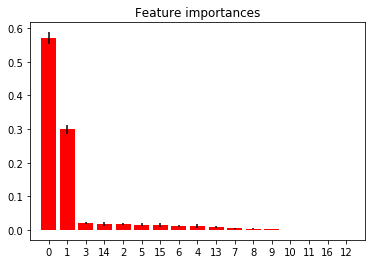

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=50)
forest.fit(X_train, y_train["revenue"])

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()
